In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline

/Users/qingemeng/Documents/dev/cs498aml/env/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Load data

In [2]:
def make_int(text):
    label = text.strip('" ')
    return int(-1 if label == '<=50K' else 1)

column_names = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
train_X = pd.read_csv('data/hw2/train.csv', usecols=[0, 2, 4, 10, 11, 12], names=column_names)
train_Y = pd.read_csv('data/hw2/train.csv', usecols=[14], names=['label'],converters={'label': make_int})

test_X = pd.read_csv('data/hw2/test.csv', usecols=[0, 2, 4, 10, 11, 12], names=column_names)
# test_Y = pd.read_csv('data/hw2/test.csv', usecols=[14], names=['label']).replace('>50K', 1).replace('<=50K', -1)

In [3]:
print(f'train data shape: {train_X.shape}')
print(f'test data shape: {test_X.shape}')
train_X.head()

train data shape: (43957, 6)
test data shape: (4885, 6)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,287315,9,0,0,40
1,43,145175,13,0,0,42
2,45,33798,14,0,0,40
3,23,180497,13,0,0,32
4,65,145628,6,0,0,40


In [4]:
train_Y.head()

,label
0,-1
1,1
2,-1
3,-1
4,-1


In [5]:
test_X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,36,126569,10,0,0,40
1,26,68346,14,0,0,10
2,58,225394,9,0,1902,40
3,60,78913,10,0,0,50
4,20,218215,10,0,0,30


## Process data

#### Scale data

In [6]:
scaled_train_X = pd.DataFrame(preprocessing.scale(train_X), columns=column_names)
scaled_test_X = pd.DataFrame(preprocessing.scale(test_X), columns=column_names)

/Users/qingemeng/Documents/dev/cs498aml/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/Users/qingemeng/Documents/dev/cs498aml/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [7]:
scaled_test_X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.198185,-0.608772,-0.028374,-0.152805,-0.223378,-0.038573
1,-0.926873,-1.177546,1.503180,-0.152805,-0.223378,-2.353443
2,1.404928,0.356638,-0.411262,-0.152805,4.230006,-0.038573
3,1.550665,-1.074318,-0.028374,-0.152805,-0.223378,0.733050
4,-1.364085,0.286507,-0.028374,-0.152805,-0.223378,-0.810197


#### Split data

In [8]:
def split_data(df, ratio):
    set1 = df.sample(frac=ratio)
    set2 = df.sample(frac=(1 - ratio))
    return set1, set2

In [9]:
regularization_train, regularization_validation = split_data(scaled_train_X.join(train_Y), 0.9)

In [10]:
assert regularization_train.shape[0] + regularization_validation.shape[0] == train_X.shape[0]
regularization_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
4315,0.756069,-0.503911,1.528019,-0.144172,-0.21644,-1.656087,-1
42230,-1.140508,-0.165338,-0.420255,-0.144172,-0.21644,0.777693,-1
16006,1.339631,-0.210403,-2.368529,-0.144172,-0.21644,-0.033567,-1
2107,0.099562,-0.493879,1.528019,-0.144172,-0.21644,-0.439197,1
28145,-0.702837,-1.510233,1.138364,-0.144172,-0.21644,-1.331583,-1


In [11]:
reg_validate_X = regularization_validation.drop(['label'], axis=1)
reg_validate_Y = regularization_validation['label']

## Stochastic Gradient Descent

In [12]:
def predict(feature_vec, a, b):
    return np.sign(np.dot(feature_vec, a.T) + b)
    
def calculate_accuracy(actual, predicts):
    TP = 0
    num_total = len(actual)
    for i in range(num_total):
        if actual[i] == predicts[i]:
            TP = TP + 1
    return TP/num_total

def evaluate(test_set, a, b):
    test_X = test_set.drop(['label'], axis=1)
    test_Y = test_set['label']
    predicts = test_X.apply(predict, args=(a, b, ), axis=1)
    return calculate_accuracy(np.array(test_Y), np.array(predicts))

In [13]:
# blah1 = np.array([1,2])
# blah2 = np.array([3,4])
# np.dot(blah2.T, blah1)

In [14]:
def gradient_of_cost(feature_vec, label, a, b, lam=0):
    if label * (np.dot(feature_vec, a.T) + b) < 1:
        gradient_a = lam * a - (feature_vec * label)
        gradient_b = 0 - label
    else:
        gradient_a = lam * a
        gradient_b = 0
  
    return [gradient_a, gradient_b]

In [15]:
def step(feature_vec, label,a, b, lam, learning_rate):
#   c = cost_function(x_batch,y_batch,a=a_est,b=b_est)
    g = gradient_of_cost(feature_vec, label,a=a,b=b,lam=lam)
    a_new = a - learning_rate * g[0]
    b_new = b - learning_rate * g[1]
    return a_new, b_new

In [16]:
def stochastic_gradient_descent(X, Y, initial_a, initial_b, steps, held_out_set, learning_rate, lam):
    a = initial_a
    b = initial_b
    plots = np.array([])
    for i in range(steps):
        n = np.random.randint(0, len(X)) # Batch size of 1.
        a, b = step(X.iloc[n], Y.iloc[n], a, b, lam, learning_rate)
        if((i+1)%30 == 0):
            accuracy = evaluate(held_out_set, a, b)
            magnitude = np.linalg.norm(a)
            plots = np.concatenate((plots, {'acc': accuracy, 'mag': magnitude}), axis=None)
#             print(f'accuracy after {i+1} steps: {accuracy}')

#     print(f"Final a = {a}\n")
#     print(f"Final b = {b}\n")
    return a, b, plots

In [17]:
def seperate_held_out(X, size):
    random_indices = np.random.randint(0, len(X), size=size)
    return X.drop(X.index[random_indices]), X.iloc[random_indices]

In [18]:
def svg_fit(train_data, learning_rate, lam, epoch=50, initial_a=np.random.rand(1,6).flatten() - 1, initial_b=0, set_held_out_size=50, steps=300):
    X, held_out_set = seperate_held_out(train_data, set_held_out_size)
    if(X.shape[0] + held_out_set.shape[0] != train_data.shape[0]):
        print(f'total: {train_data.shape}, X.shape: {X.shape}, held out shape: {held_out_set.shape}')

    train_X = X.drop(['label'], axis=1)
    train_Y = X['label']
    a, b = initial_a, initial_b
    plots_each_lambda = np.array([])
    for i in tqdm(range(epoch)):
        a, b, plots_each_epoch = stochastic_gradient_descent(train_X, train_Y, a, b, steps, held_out_set, learning_rate=learning_rate, lam=lam)
        plots_each_lambda = np.concatenate((plots_each_lambda, plots_each_epoch), axis=None)
    return a, b, plots_each_lambda

In [19]:
# lambdas = [1e-8, 1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1]
lambdas = [1e-7, 1e-5]
epoch = 50
plots = []
for lam in lambdas:
    learning_rate = 1/(0.01* epoch + 50)
    a, b, plots_each_lambda = svg_fit(regularization_train, epoch=epoch, learning_rate=learning_rate, lam=lam)
    plots.append(plots_each_lambda)
    print(np.array(a), b)
    accuracy = evaluate(regularization_validation, a, b)
    print(f'lamda: {lam}, Accuracy: {accuracy}')
# print(accuracies.shape)


[ 0.11041466 -0.02695254  0.11604041  1.99856496  0.05601505 -0.01438663] -0.7722772277227725
lamda: 1e-08, Accuracy: 0.7995905368516834



[ 0.19155253 -0.02791216  0.14992428  1.97066212  0.11276669  0.10298871] -0.8712871287128716
lamda: 1e-07, Accuracy: 0.8034576888080073



[ 0.04502766  0.03391984  0.12580884  1.81587653 -0.03555314 -0.04703164] -0.8712871287128716
lamda: 1e-05, Accuracy: 0.8034576888080073



[ 0.1875996  -0.02159943  0.26139712  1.37715461  0.5139463   0.3450899 ] -0.8712871287128716
lamda: 0.001, Accuracy: 0.8066424021838035



[0.29790158 0.1136051  0.42836773 1.30510815 0.07808276 0.19044583] -0.8910891089108914
lamda: 0.01, Accuracy: 0.8121019108280255



[ 0.07245183 -0.04314336  0.1008032   0.50970218  0.05847047  0.18058766] -0.9108910891089113
lamda: 0.1, Accuracy: 0.7873066424021838



[ 0.01900355  0.0274725  -0.00916755  0.077215   -0.00822128  0.00751247] -1.0297029702970302
lamda: 1, Accuracy: 0.7672884440400364


In [20]:
len(plots)

7

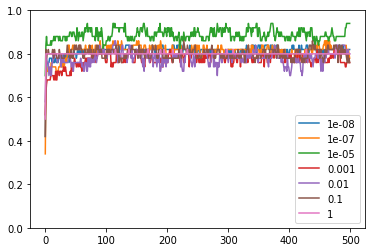

In [21]:
for plot_x in plots:
    accs = []
    for pairs in plot_x:
        accs.append(pairs['acc'])
    
    plt.plot(range(epoch*300//30), accs)
plt.gca().set_ylim(0, 1)
plt.legend(lambdas)
plt.show()

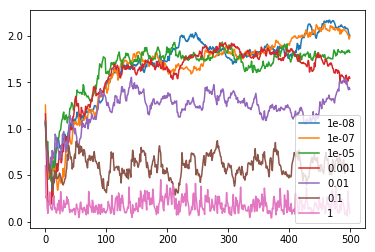

In [22]:
for plot_x in plots:
    mags = []
    for pairs in plot_x:
        mags.append(pairs['mag'])
    
    plt.plot(range(epoch*300//30), mags)
plt.legend(lambdas)
plt.show()
